<a href="https://www.kaggle.com/code/aliniazi3/spotcancerai?scriptVersionId=246520259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/efficientnetb5/tensorflow2/default/1/efficientnetb5_notop.h5
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_image


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.impute import SimpleImputer

from glob import glob
from PIL import Image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf

# **DATA READING**

In [3]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
df.shape

(10015, 7)

# **DATA Preprocessing**

**Creating dictionary for displaying more human-friendly labels.**

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# **Merge images from both folders into one dictionary**

In [7]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# **Creating new columns for better understanding of features**

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
1  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
2  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
3  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
4  ../input/skin-cancer-mnist-ham10000/ham10000_i...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

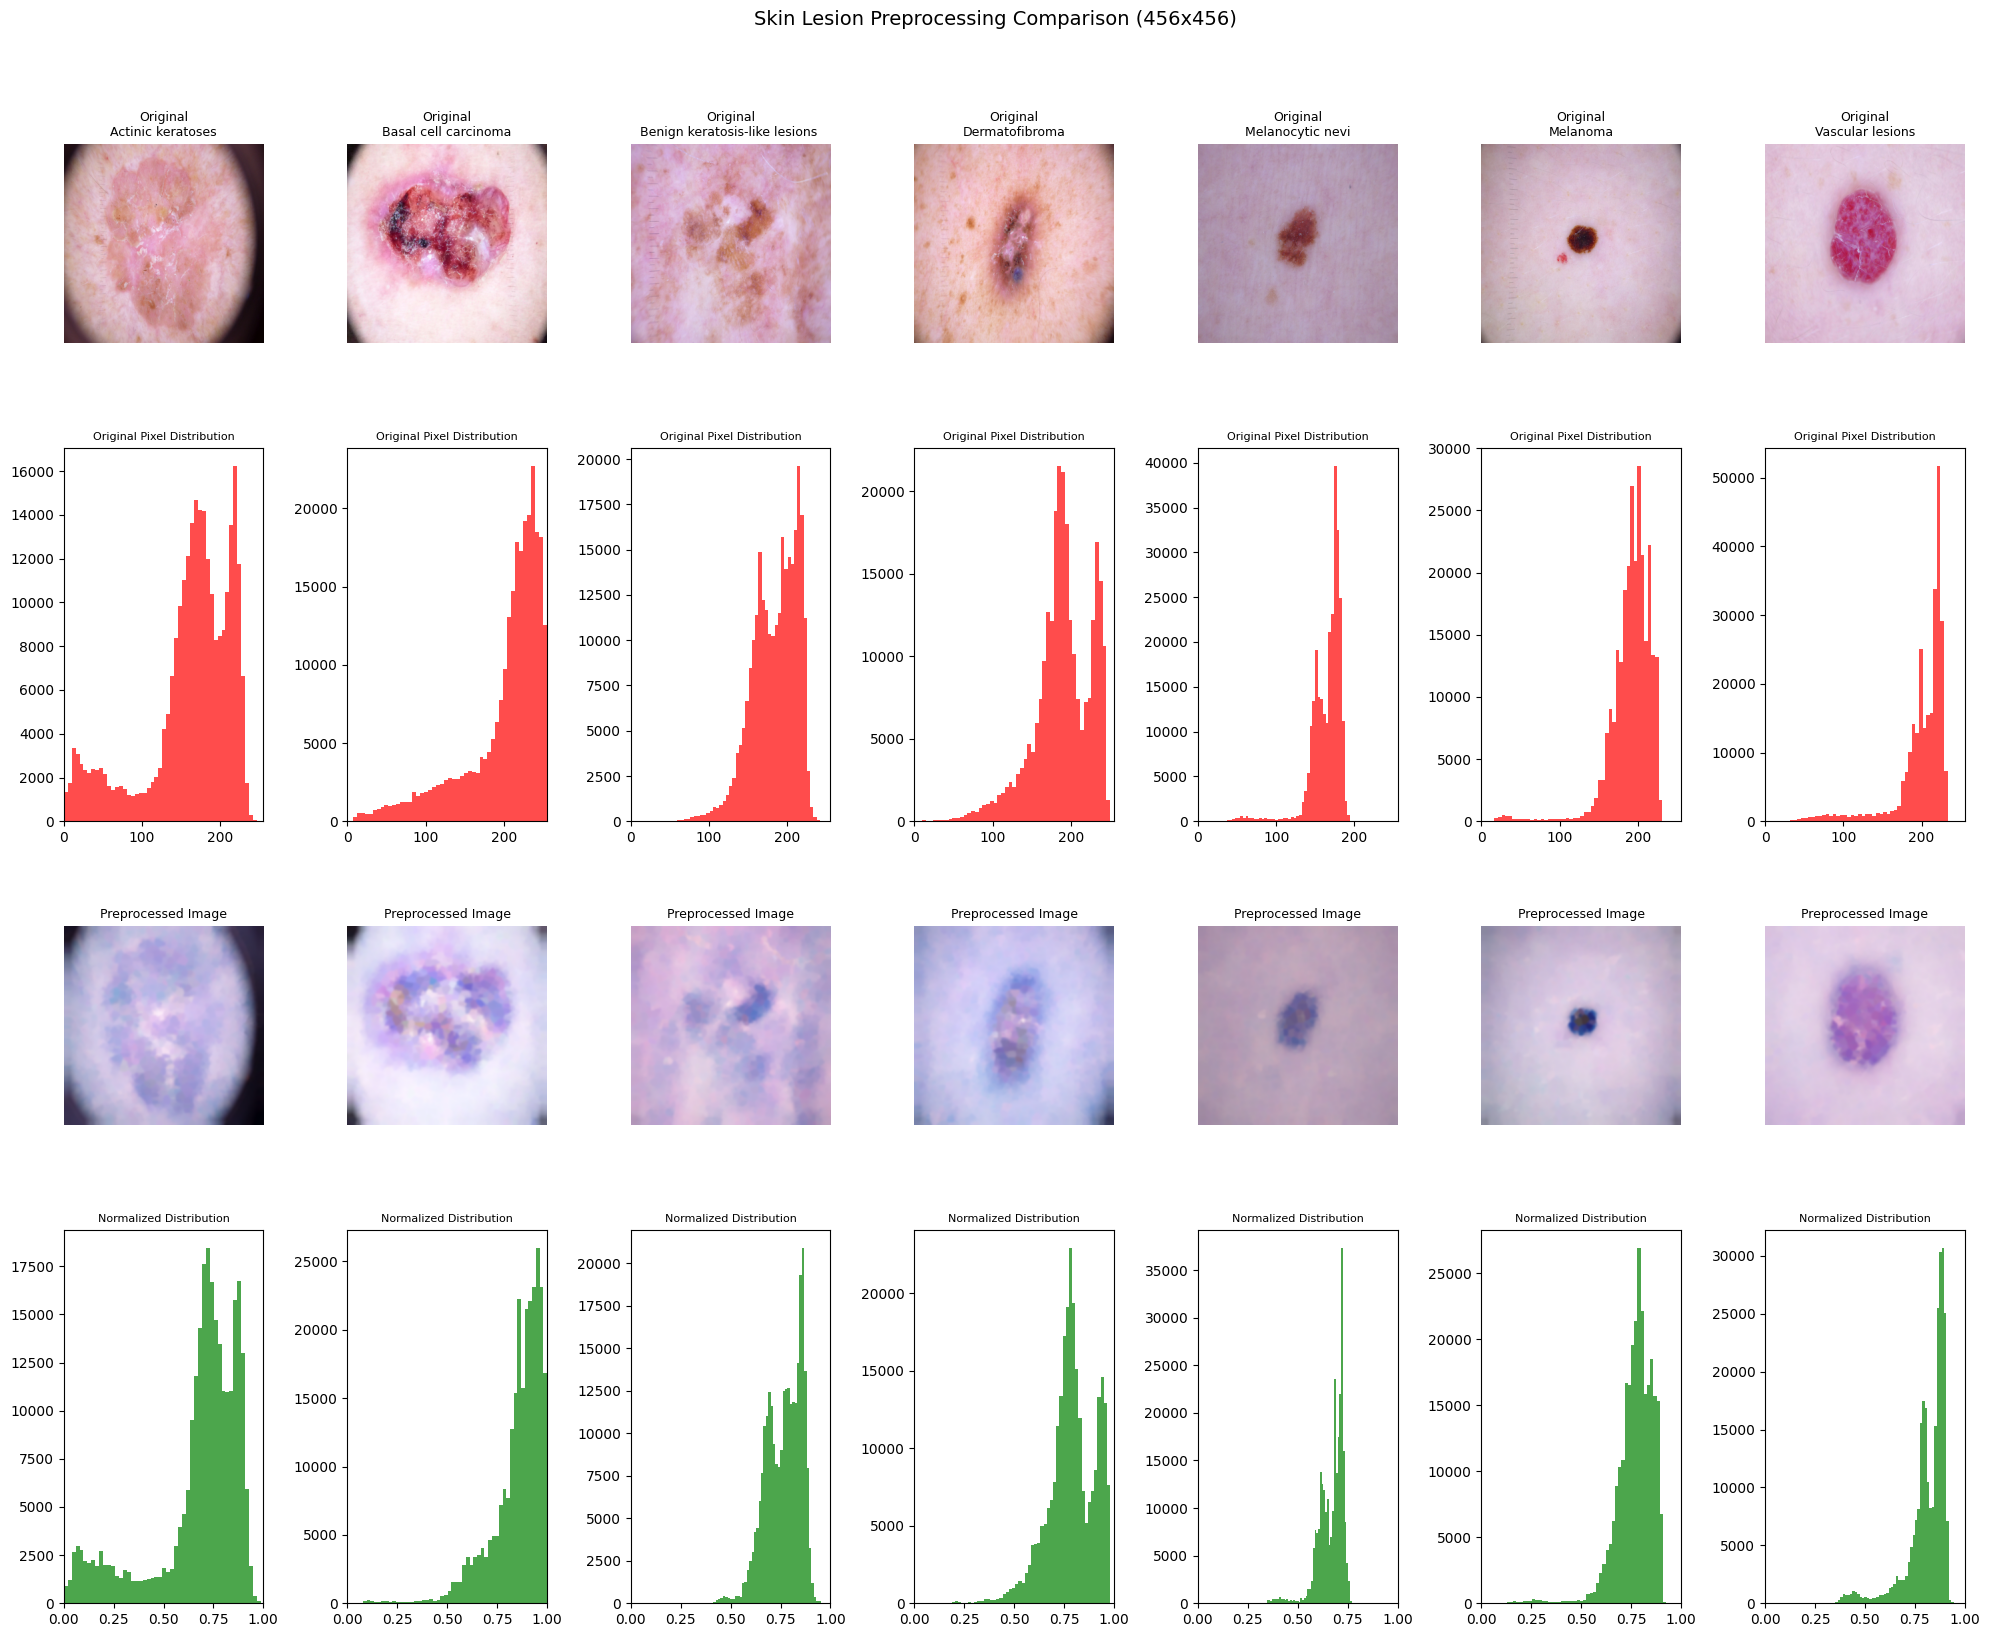

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, IMAGE_SIZE=300):
    # Read and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Convert to grayscale and apply blackhat
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Inpainting and denoising
    inpainted = cv2.inpaint(img, blackhat, 1, cv2.INPAINT_TELEA)
    denoised = cv2.GaussianBlur(inpainted, (7, 7), 0)
    
    # Normalize to [0,1]
    normalized = denoised.astype('float32') / 255.0
    
    return normalized

# Get sample images (one per class)
sample_images = df.groupby('cell_type').first().reset_index()

plt.figure(figsize=(20, 16))

for i, row in enumerate(sample_images.itertuples(), 1):
    if i > 7: break  # Show all 7 classes
    
    # Original image processing
    original = cv2.imread(row.path)
    original = cv2.resize(original, (300, 300))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Preprocessed image
    processed = preprocess_image(row.path)
    
    # Create subplots
    # Original Image
    plt.subplot(4, 7, i)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{row.cell_type}", fontsize=9)
    plt.axis('off')
    
    # Original Histogram
    plt.subplot(4, 7, i+7)
    plt.hist(original_rgb.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Original Pixel Distribution", fontsize=8)
    plt.xlim(0, 255)
    
    # Processed Image
    plt.subplot(4, 7, i+14)
    plt.imshow((processed * 255).astype('uint8'))  # Convert back for display
    plt.title("Preprocessed Image", fontsize=9)
    plt.axis('off')
    
    # Processed Histogram
    plt.subplot(4, 7, i+21)
    plt.hist(processed.ravel(), bins=50, color='green', alpha=0.7)
    plt.title("Normalized Distribution", fontsize=8)
    plt.xlim(0, 1)

plt.tight_layout()
plt.suptitle("Skin Lesion Preprocessing Comparison (456x456)", y=1.02, fontsize=14)
plt.show()

In [10]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

# **Exploratory Data Analysis (EDA)**

In [11]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [12]:
classes = {
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', ' basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', ' melanocytic nevi'),
    5: ('vasc', ' pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma')
}


# **Frequency Distribution of Classes**

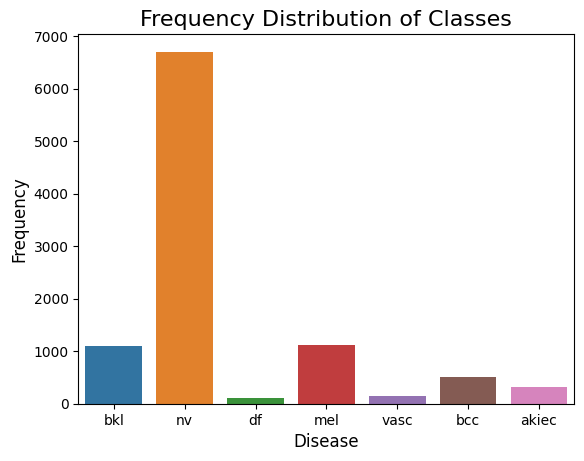

In [13]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

# **Distribution of Disease over Gender**

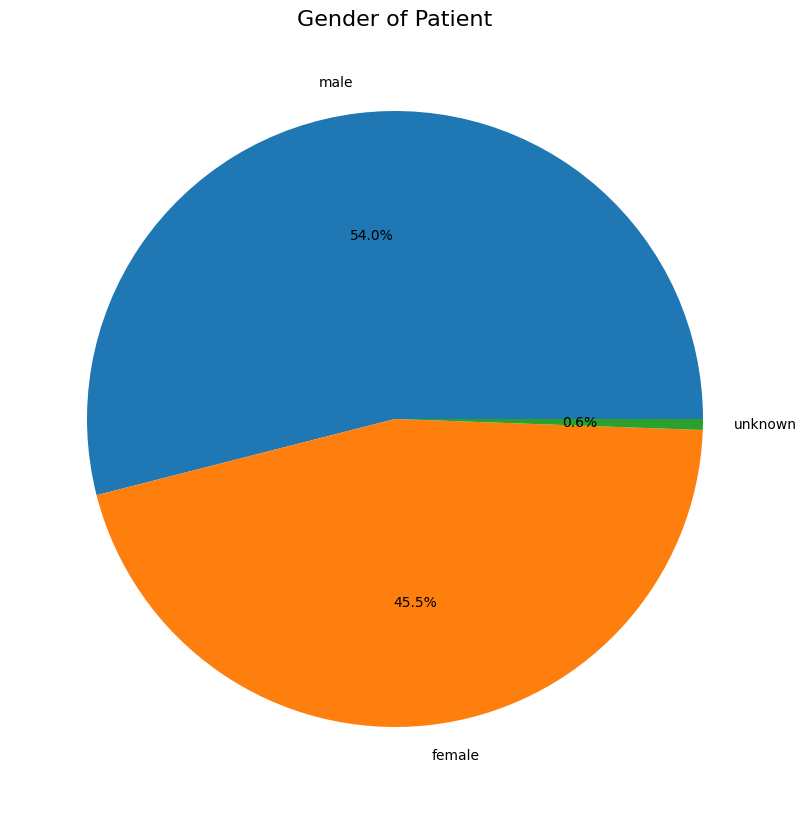

In [14]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)
plt.show()

# **Histogram of Age of Patients**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


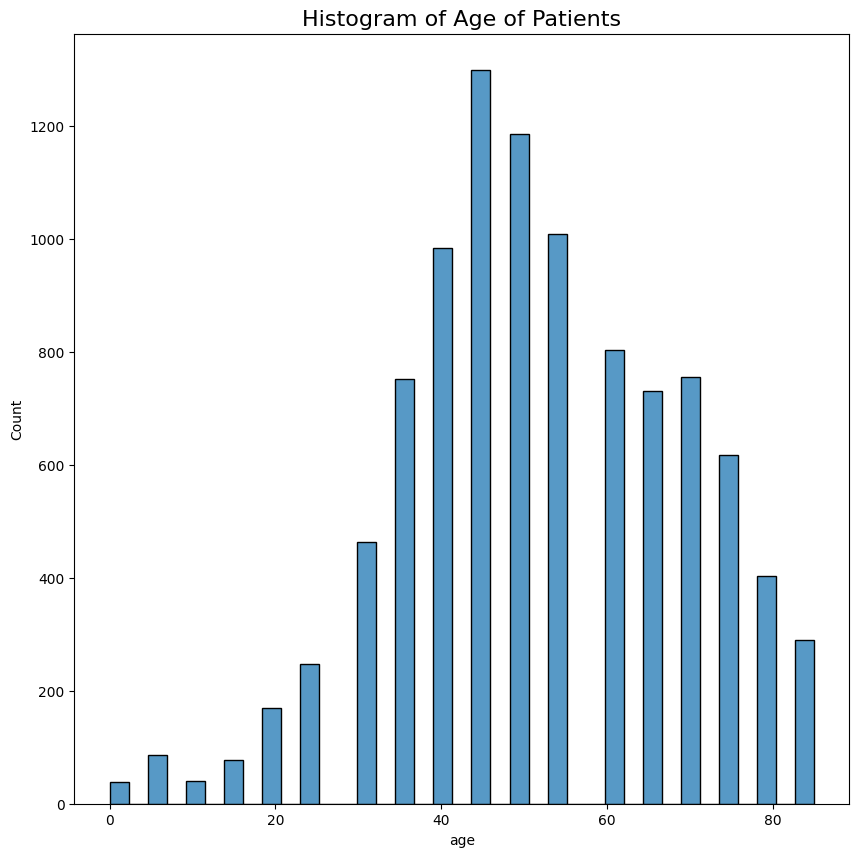

In [15]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)
plt.show()

# **Location of disease over Gender**

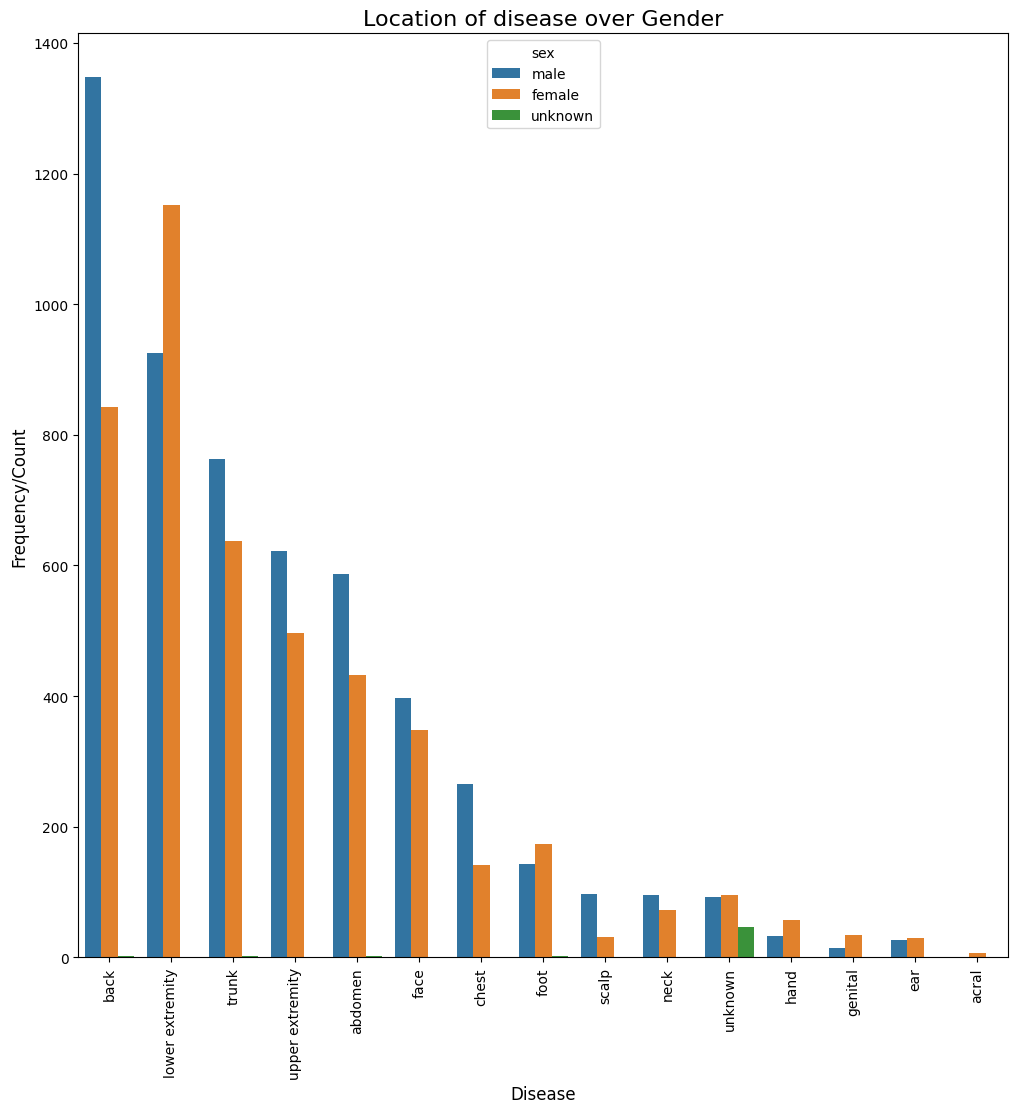

In [16]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)
plt.show()

# **Data Splitting**

In [17]:
X = df['path'].values
y = df['dx'].values
from sklearn.model_selection import train_test_split

# 1. 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Split temp into 10% val and 20% test (from original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2%})")


Train size: 7010 (70.00%)
Validation size: 1001 (10.00%)
Test size: 2004 (20.01%)


# **Combine into DataFrames**

In [18]:
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
val_df = pd.DataFrame({'path': X_val, 'label': y_val})
test_df = pd.DataFrame({'path': X_test, 'label': y_test})

# Convert labels to string for generators
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# **Augmentation**

In [19]:
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()
print("Original class distribution:\n", class_counts)


Original class distribution:
 label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64


In [20]:
augmented_dir = "/kaggle/working/augmented_dataset"
os.makedirs(augmented_dir, exist_ok=True)

In [21]:
import os
import uuid
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Constants
IMAGE_SIZE = 300
augmented_dir = "/kaggle/working/augmented_dataset"

# Ensure output directory exists
os.makedirs(augmented_dir, exist_ok=True)

# Step 1: Count class samples
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()
majority_class = class_counts.idxmax()

print(f"✅ Majority class is: '{majority_class}' with {max_count} samples.\n")

# Step 2: Create folders & copy original images
for label in train_df['label'].unique():
    class_folder = os.path.join(augmented_dir, label)
    os.makedirs(class_folder, exist_ok=True)

    # Copy original images
    class_df = train_df[train_df['label'] == label]
    for _, row in class_df.iterrows():
        src = row['path']
        dst = os.path.join(class_folder, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

# Step 3: Set up augmentation
augmenter = ImageDataGenerator(
   rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Step 4: Augment only minority classes
augmented_records = []

for label in class_counts.index:
    if label == majority_class:
        print(f"Skipping augmentation for majority class '{label}'.\n")
        continue

    class_df = train_df[train_df['label'] == label]
    current_count = len(class_df)
    n_needed = max_count - current_count

    print(f"Augmenting class '{label}' with {n_needed} images...")

    class_folder = os.path.join(augmented_dir, label)

    generated = 0
    while generated < n_needed:
        for _, row in class_df.iterrows():
            img = load_img(row['path'], target_size=(IMAGE_SIZE, IMAGE_SIZE))
            x = img_to_array(img).reshape((1,) + (IMAGE_SIZE, IMAGE_SIZE, 3))

            for batch in augmenter.flow(x, batch_size=1):
                out_filename = f"{uuid.uuid4().hex}.jpg"
                out_path = os.path.join(class_folder, out_filename)
                array_to_img(batch[0]).save(out_path)

                # ✅ Track new image in augmented_records
                augmented_records.append({'path': out_path, 'label': label})
                
                generated += 1
                break

            if generated >= n_needed:
                break

✅ Majority class is: 'nv' with 4693 samples.

Skipping augmentation for majority class 'nv'.

Augmenting class 'mel' with 3914 images...
Augmenting class 'bkl' with 3924 images...
Augmenting class 'bcc' with 4333 images...
Augmenting class 'akiec' with 4464 images...
Augmenting class 'vasc' with 4594 images...
Augmenting class 'df' with 4612 images...


In [22]:
import shutil

# Define output zip path
zip_name = "/kaggle/working/augmented_dataset.zip"

# Create ZIP archive
shutil.make_archive(zip_name.replace('.zip', ''), 'zip', augmented_dir)

print(f"\n✅ ZIP file created at: {zip_name}")



✅ ZIP file created at: /kaggle/working/augmented_dataset.zip


In [23]:
augmented_df = pd.DataFrame(augmented_records)
balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

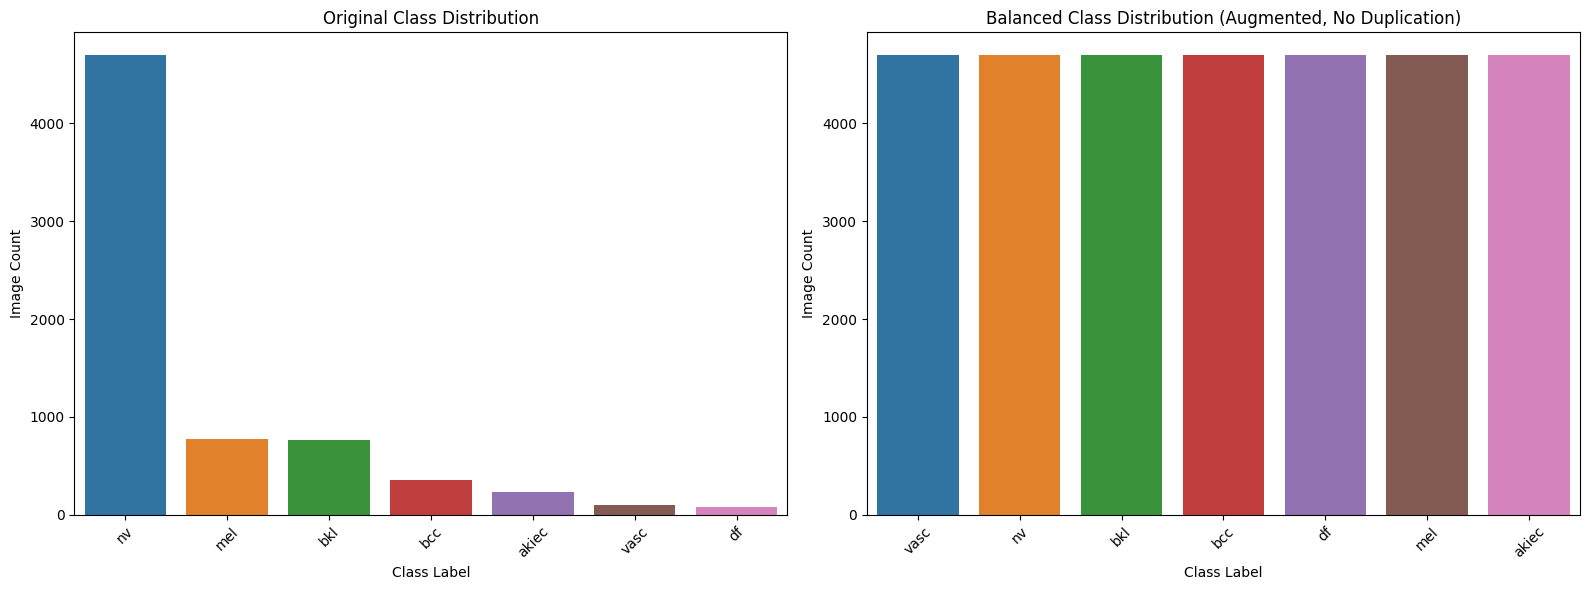

In [24]:
plt.figure(figsize=(16, 6))

# --- Plot 1: Original Data Distribution ---
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title("Original Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.xticks(rotation=45)

# --- Plot 2: Balanced Data Distribution ---
plt.subplot(1, 2, 2)
sns.countplot(data=balanced_train_df, x='label', order=balanced_train_df['label'].value_counts().index)
plt.title("Balanced Class Distribution (Augmented, No Duplication)")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **One-hot encode the labels And Data Generators (for categorical classification)**

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Ensure labels are string type (important for categorical labels)
balanced_train_df['label'] = balanced_train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

IMAGE_SIZE = 300  # EfficientNetB5 input size
BATCH_SIZE = 16
seed = 42
    
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

# Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

print("Train classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
plt.show()

Found 32851 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 2004 validated image filenames belonging to 7 classes.
Train classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Train samples: 32851
Validation samples: 1001
Test samples: 2004


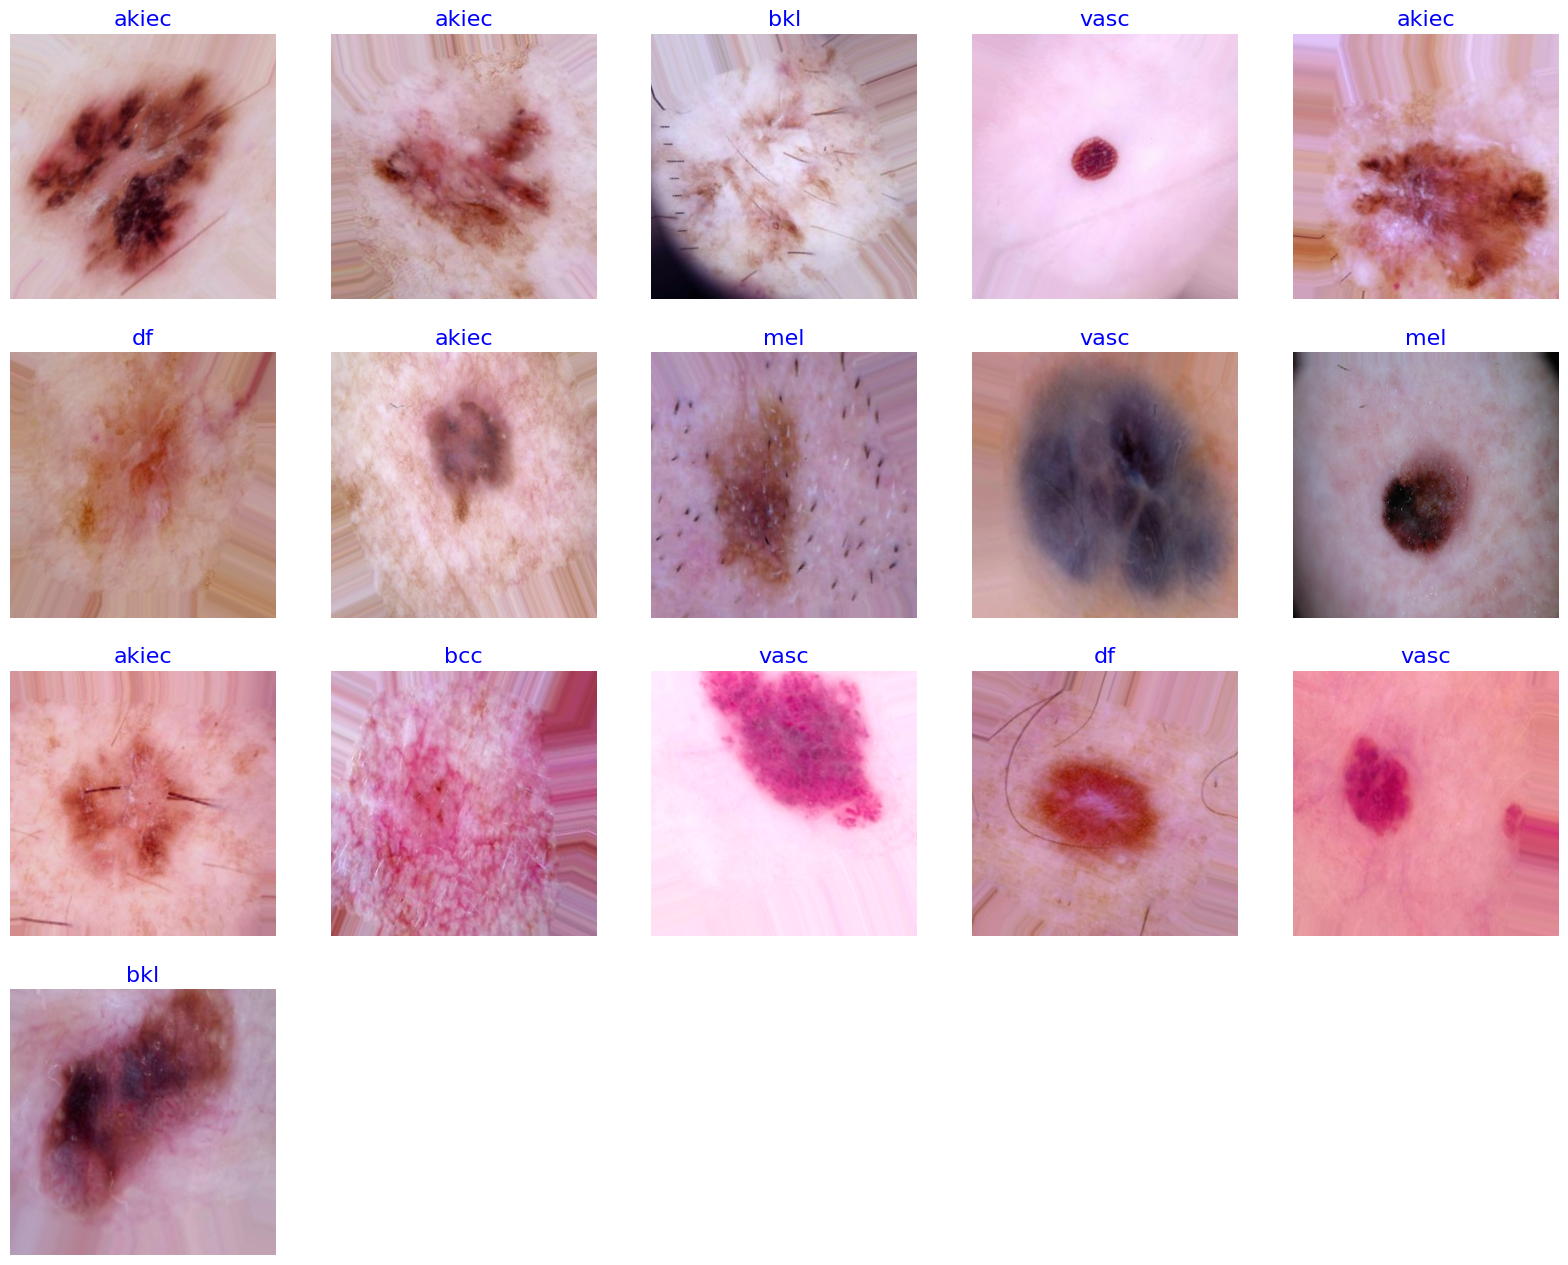

In [26]:
def show_image_samples(gen ):
    test_dict=test_generator.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_generator)

# **Build and compile the EfficientNetB5 model**

In [27]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense ,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define image size for EfficientNetB5
IMAGE_SIZE = 300  
BATCH_SIZE = 16
num_classes = 7
# Load EfficientNetB5 without top layer
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':
        layer.trainable = True
    
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,073,406 (110.91 MB)

 Trainable params: 744,967 (2.84 MB)

 Non-trainable params: 28,328,439 (108.06 MB)

# **Train the model**

In [28]:
import warnings
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 841s 383ms/step - accuracy: 0.3798 - loss: 2.4337 - val_accuracy: 0.7123 - val_loss: 1.4581 - learning_rate: 1.0000e-04
Epoch 2/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 734s 356ms/step - accuracy: 0.6387 - loss: 1.6007 - val_accuracy: 0.7403 - val_loss: 1.2893 - learning_rate: 1.0000e-04
Epoch 3/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 731s 354ms/step - accuracy: 0.7210 - loss: 1.3297 - val_accuracy: 0.7612 - val_loss: 1.1747 - learning_rate: 1.0000e-04
Epoch 4/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 731s 354ms/step - accuracy: 0.7729 - loss: 1.1434 - val_accuracy: 0.7702 - val_loss: 1.1149 - learning_rate: 1.0000e-04
Epoch 5/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 733s 356ms/step - accuracy: 0.8025 - loss: 1.0056 - val_accuracy: 0.7962 - val_loss: 1.0112 - learning_rate: 1.0000e-04
Epoch 6/40
2054/2054 ━━━━━━━━━━━━━━━━━━━━ 732s 355ms/step - accuracy: 0.8334 - loss: 0.8936 - val_accuracy: 0.8082 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 7/40
2054/2054 ━━━━━━━

In [29]:
# Example: Find epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['accuracy']) + 1  # +1 because indexing starts from 0
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

Best Epoch: 31
Accuracy at Best Epoch: 0.9660


In [30]:
import os
import shutil

# Create directory to save model
save_dir = '/kaggle/working/my_model'
os.makedirs(save_dir, exist_ok=True)

# Save model as HDF5 file
model.save(os.path.join(save_dir, 'SpotCancerAI.h5'))

# Create a zip file of the directory
shutil.make_archive('/kaggle/working/Final_Model', 'zip', save_dir)


'/kaggle/working/Final_Model.zip'

# **Plot Training History (Accuracy & Loss)**

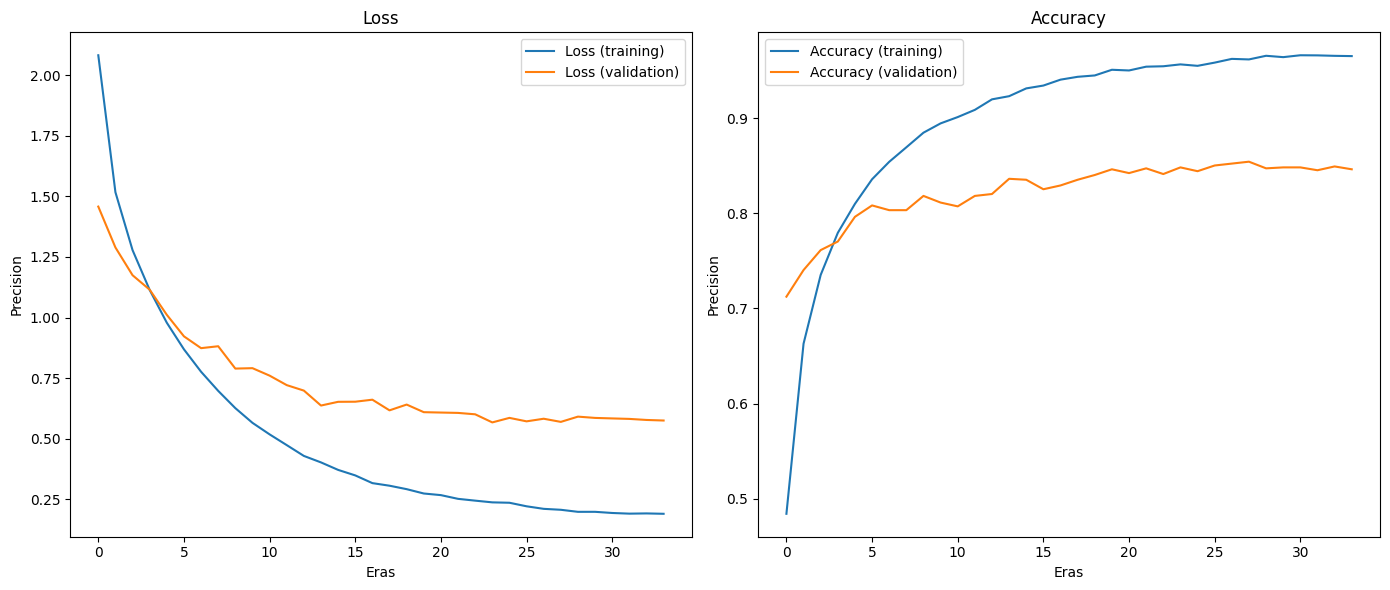

In [31]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluate the Model on Test Data**

In [32]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2004/2004 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.8673 - loss: 0.5986
Test Loss: 0.6189
Test Accuracy: 0.8543


# **Confusion Metrix**

2004/2004 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step
Classification Report:

              precision    recall  f1-score   support

       akiec       0.88      0.55      0.68        65
         bcc       0.84      0.70      0.76       103
         bkl       0.71      0.74      0.72       220
          df       1.00      0.64      0.78        22
         mel       0.75      0.49      0.59       223
          nv       0.89      0.97      0.92      1342
        vasc       0.96      0.76      0.85        29

    accuracy                           0.85      2004
   macro avg       0.86      0.69      0.76      2004
weighted avg       0.85      0.85      0.85      2004



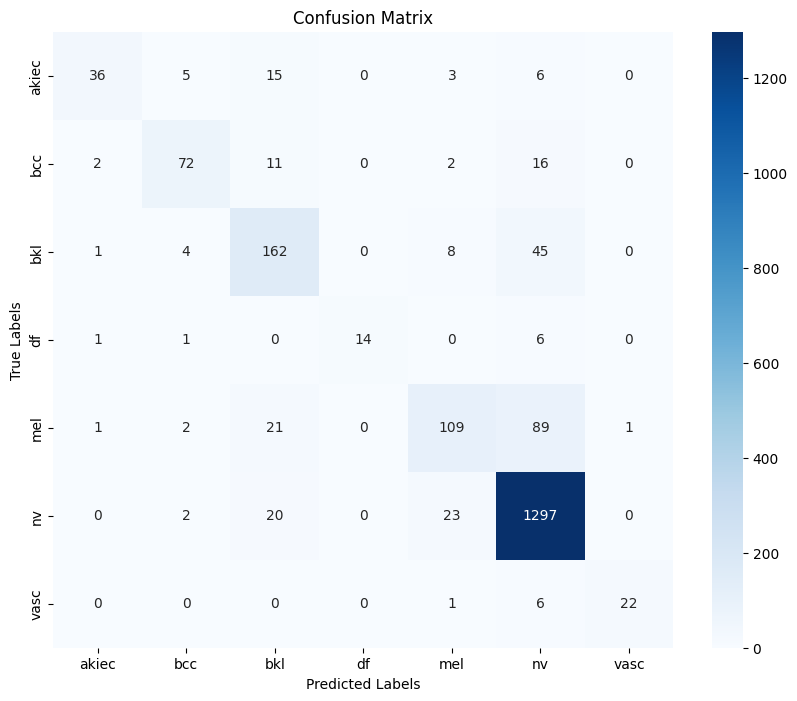

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Get predicted probabilities
y_prob = model.predict(test_generator)

# Step 2: Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Step 3: Get true labels from the generator
y_true = test_generator.classes

# Step 4: Get label names from generator
labels = list(test_generator.class_indices.keys())

# Step 5: Print Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 6: Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()